## Imports and global variables

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt

## Generating and splitting data

In [2]:
def split_into_train_test_val(features, labels, train_size=0.8, test_size=0.2, val_size=None, seed=None):
    # Calculate the validation size if not provided
    if val_size is None:
        val_size = 1.0 - train_size - test_size
        if val_size < 0.0:
            raise ValueError("Sum of train and test sizes exceeds 1.0")

    # Check if the sizes sum up to 1.0 (or 100%)
    if not (train_size + test_size + val_size == 1.0):
        raise ValueError("Train, test, and validation sizes must sum up to 1.0.")

    # Set the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Get the total number of samples
    n_samples = len(features)

    # Create a shuffled array of indices
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    # Compute split points
    train_end = int(n_samples * train_size)
    test_end = train_end + int(n_samples * test_size)

    # Split indices into training, testing, and validation based on the sizes
    train_indices = indices[:train_end]
    test_indices = indices[train_end:test_end]
    val_indices = indices[test_end:]

    # Split features and labels into training, testing, and validation sets
    X_train = [features[i] for i in train_indices]
    X_test = [features[i] for i in test_indices]
    X_val = [features[i] for i in val_indices]

    y_train = [labels[i] for i in train_indices]
    y_test = [labels[i] for i in test_indices]
    y_val = [labels[i] for i in val_indices]

    return X_train, X_test, X_val, y_train, y_test, y_val

def sequences_data_generator(num_sequences, min_length=0, max_length=16):
    sequences = []
    labels = []

    for _ in range(num_sequences):
        length = np.random.randint(min_length, max_length + 1)  # Random length between 1 and max_length
        sequence = np.random.randint(0, 2, length)  # Random binary sequence of the given length
        sequences.append(sequence)
        labels.append(np.sum(sequence))  # Count of '1's in the sequence

    return sequences, labels

num_sequences = 100_000
sequences, labels = sequences_data_generator(num_sequences, 0, 16) # 0 and 16 both inclusive
print("Data generated")

train_size = 0.8
val_size = 0.1
test_size = 0.1

X_train, X_test, X_val, y_train, y_test, y_val = split_into_train_test_val(sequences, labels, train_size, test_size, val_size, seed=42)
print("Data split into train, test and val set")

Data generated
Data split into train, test and val set


## Dataset class

In [3]:
# Custom dataset class
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor([float(bit) for bit in self.sequences[idx]], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return sequence, label

## RNN Class

In [4]:
def function_to_collate(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return padded_sequences, labels

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def load_data(self, X_train, X_val, y_train, y_val, batch_size=32):
        self.batch_size = batch_size

        self.train_dataset = SequenceDataset(X_train, y_train)
        self.val_dataset = SequenceDataset(X_val, y_val)

        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True, collate_fn=function_to_collate)
        self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False, collate_fn=function_to_collate)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        output, _ = self.rnn(x, h0)
        last_output = output[:, -1, :]
        normalized = self.layer_norm(last_output)
        prediction = self.fc(normalized)
        return prediction.squeeze()

    def train_model(self, loss="MSE", optimizer="Adam", lr=0.001, num_epochs=10):
        # Initiating Loss
        if loss == "MAE":
            self.criterion = nn.L1Loss()  # MAE
        elif loss == "MSE":
            self.criterion = nn.MSELoss()  # MSE
        elif loss == "BCE":
            self.criterion = nn.BCELoss()  # BCE

        # Initiating Optimiser
        if optimizer == "Adam":
            self.optimizer = optim.Adam(self.parameters(), lr=lr)
        elif optimizer == "SGD":
            self.optimizer = optim.SGD(self.parameters(), lr=lr)

        train_loss_arr = list()
        val_loss_arr = list()
        mae_arr = list()

        # Training loop
        for epoch in range(num_epochs):
            self.train()
            train_loss = 0
            for sequences, labels in self.train_loader:
                sequences = sequences.unsqueeze(-1)  # Add an extra dimension for input_size

                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = self.forward(sequences)
                loss = self.criterion(outputs.squeeze(), labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

            train_loss /= len(self.train_loader)
            train_loss_arr.append(train_loss)

            # Validation loop
            self.eval()
            val_loss = 0
            mae = 0

            with torch.no_grad():
                for sequences, labels in self.val_loader:
                    sequences = sequences.unsqueeze(-1)

                    sequences = sequences.to(device)
                    labels = labels.to(device)

                    outputs = self.forward(sequences)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item()

                    mae += torch.mean(torch.abs(outputs.squeeze() - labels)).item()

            val_loss /= len(self.val_loader)
            val_loss_arr.append(val_loss)
            avg_mae = mae / len(self.val_loader)
            mae_arr.append(avg_mae)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {round(train_loss, 3)}, Validation Loss: {round(val_loss, 3)}, Val MAE: {round(avg_mae, 3)}')

        return train_loss_arr, val_loss_arr, mae_arr

    def get_loss(self, X_test, y_test):
        test_dataset = SequenceDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=function_to_collate)

        self.eval()
        test_loss = 0
        mae_loss = 0

        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences = sequences.unsqueeze(-1)

                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = self.forward(sequences)
                loss = self.criterion(outputs.squeeze(), labels)
                test_loss += loss.item()

                mae_loss += torch.mean(torch.abs(outputs.squeeze() - labels)).item()

        test_loss /= len(test_loader)
        mae_loss /= len(test_loader)
        return test_loss, mae_loss

## Function to plot the loss graph

In [5]:
def plot_loss_and_mae_graph(train_loss_arr, val_loss_arr, mae_arr):
    plt.figure(figsize=(12, 7))
    epochs = range(1, len(train_loss_arr) + 1)

    # Plot training and validation losses
    plt.plot(epochs, train_loss_arr, color='darkorange', linestyle='-', marker='o', label='Training Loss', linewidth=2.5)
    plt.plot(epochs, val_loss_arr, color='teal', linestyle='--', marker='s', label='Validation Loss', linewidth=2.5)

    # Plot MAE array with a new style
    plt.plot(epochs, mae_arr, color='purple', linestyle='-.', marker='^', label='MAE', linewidth=2.5)

    # Fill between training and validation losses for visual interest
    plt.fill_between(epochs, train_loss_arr, val_loss_arr, color='lightgray', alpha=0.3)

    # Title and labels
    plt.title('Training, Validation Loss, and MAE over Epochs', fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('Epochs', fontsize=13)
    plt.ylabel('Loss (MAE)', fontsize=13)

    # Grid settings
    plt.grid(True, linestyle='-.', color='lightgray', alpha=0.6)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.3)

    # Custom ticks and layout
    plt.xticks(epochs[::2], fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    plt.legend(loc='upper right', fontsize=12)
    plt.show()

## Hyperparameters

In [6]:
hyperparams1 = {
    "input_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "output_size": 1,
    "num_epochs": 20,
    "batch_size": 32,
    "learning_rate": 0.001
}

hyperparams2 = {
    "input_size": 1,
    "hidden_size": 128,
    "num_layers": 3,
    "output_size": 1,
    "num_epochs": 20,
    "batch_size": 32,
    "learning_rate": 0.001
}

hyperparams3 = {
    "input_size": 1,
    "hidden_size": 32,
    "num_layers": 10,
    "output_size": 1,
    "num_epochs": 20,
    "batch_size": 32,
    "learning_rate": 0.001
}

hyperparams4 = {
    "input_size": 1,
    "hidden_size": 64,
    "num_layers": 5,
    "output_size": 1,
    "num_epochs": 20,
    "batch_size": 32,
    "learning_rate": 0.001
}

hyperparams5 = {
    "input_size": 1,
    "hidden_size": 64,
    "num_layers": 5,
    "output_size": 1,
    "num_epochs": 20,
    "batch_size": 32,
    "learning_rate": 0.1
}

## Selecting Device

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Training Models

### Model 1

In [ ]:
model1 = RNNModel(hyperparams1["input_size"], hyperparams1["hidden_size"], hyperparams1["num_layers"], hyperparams1["output_size"])
model1.to(device)
model1.load_data(X_train, X_val, y_train, y_val, batch_size=hyperparams1["batch_size"])
train_loss_arr1, val_loss_arr1, mae_arr1 = model1.train_model(loss="MSE", optimizer="Adam", lr=hyperparams1["learning_rate"], num_epochs=hyperparams1["num_epochs"])
mse_loss1, mae_loss1 = model1.get_loss(X_test, y_test)
print(f'Test Loss (MSE): {round(mse_loss1, 3)}, Test Loss (MAE): {round(mae_loss1, 3)}')

Epoch [1/20], Train Loss: 1.002, Validation Loss: 0.094, Val MAE: 0.253
Epoch [2/20], Train Loss: 0.504, Validation Loss: 0.061, Val MAE: 0.167
Epoch [3/20], Train Loss: 0.422, Validation Loss: 0.062, Val MAE: 0.177
Epoch [4/20], Train Loss: 0.409, Validation Loss: 0.31, Val MAE: 0.471
Epoch [5/20], Train Loss: 0.379, Validation Loss: 0.175, Val MAE: 0.351
Epoch [6/20], Train Loss: 0.345, Validation Loss: 0.081, Val MAE: 0.223
Epoch [7/20], Train Loss: 0.317, Validation Loss: 0.052, Val MAE: 0.144
Epoch [8/20], Train Loss: 0.284, Validation Loss: 0.045, Val MAE: 0.13
Epoch [9/20], Train Loss: 0.267, Validation Loss: 0.045, Val MAE: 0.127
Epoch [10/20], Train Loss: 0.195, Validation Loss: 0.02, Val MAE: 0.102
Epoch [11/20], Train Loss: 0.184, Validation Loss: 0.017, Val MAE: 0.088
Epoch [12/20], Train Loss: 0.178, Validation Loss: 0.045, Val MAE: 0.159
Epoch [13/20], Train Loss: 0.186, Validation Loss: 0.033, Val MAE: 0.097
Epoch [14/20], Train Loss: 0.173, Validation Loss: 0.01, Val MA

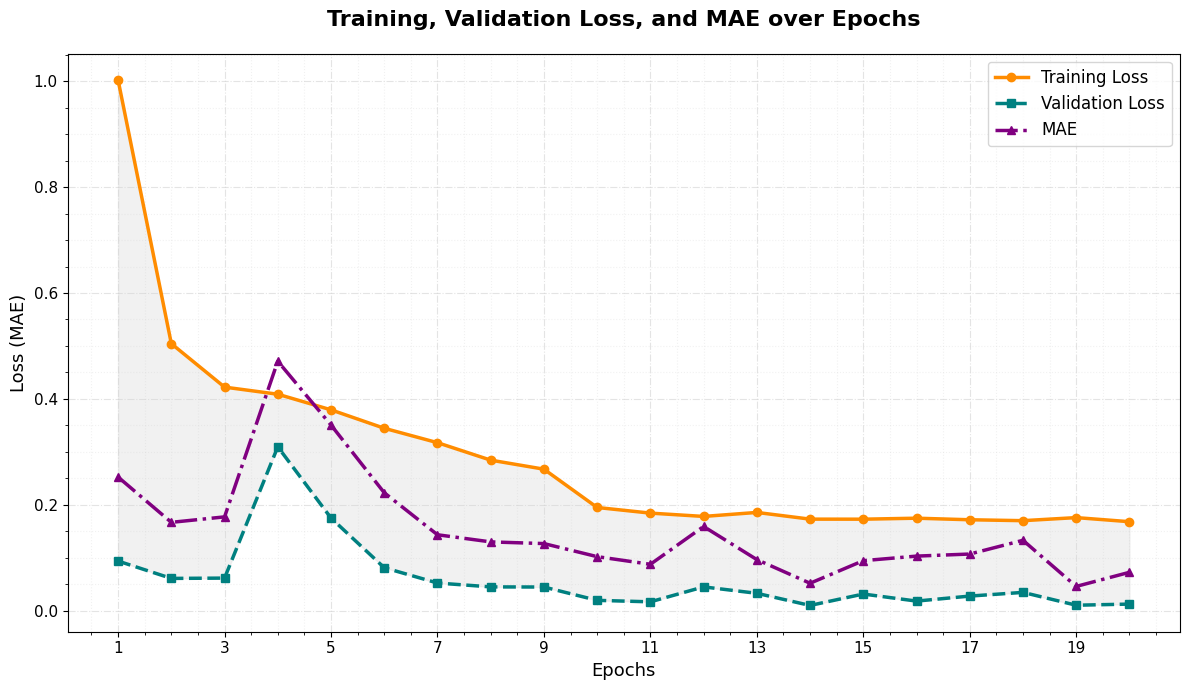

In [ ]:
plot_loss_and_mae_graph(train_loss_arr1, val_loss_arr1, mae_arr1)

### Model 2

In [ ]:
model2 = RNNModel(hyperparams2["input_size"], hyperparams2["hidden_size"], hyperparams2["num_layers"], hyperparams2["output_size"])
model2.to(device)
model2.load_data(X_train, X_val, y_train, y_val, batch_size=hyperparams2["batch_size"])
train_loss_arr2, val_loss_arr2, mae_arr2 = model2.train_model(loss="MSE", optimizer="Adam", lr=hyperparams2["learning_rate"], num_epochs=hyperparams2["num_epochs"])
mse_loss2, mae_loss2 = model2.get_loss(X_test, y_test)
print(f'Test Loss (MSE): {round(mse_loss2, 3)}, Test Loss (MAE): {round(mae_loss2, 3)}')

Epoch [1/20], Train Loss: 0.597, Validation Loss: 0.202, Val MAE: 0.363
Epoch [2/20], Train Loss: 0.348, Validation Loss: 0.061, Val MAE: 0.16
Epoch [3/20], Train Loss: 0.303, Validation Loss: 0.078, Val MAE: 0.164
Epoch [4/20], Train Loss: 0.289, Validation Loss: 0.134, Val MAE: 0.234
Epoch [5/20], Train Loss: 0.159, Validation Loss: 0.022, Val MAE: 0.082
Epoch [6/20], Train Loss: 0.163, Validation Loss: 0.023, Val MAE: 0.065
Epoch [7/20], Train Loss: 0.128, Validation Loss: 0.016, Val MAE: 0.054
Epoch [8/20], Train Loss: 0.211, Validation Loss: 0.18, Val MAE: 0.315
Epoch [9/20], Train Loss: 0.229, Validation Loss: 0.046, Val MAE: 0.105
Epoch [10/20], Train Loss: 0.197, Validation Loss: 0.169, Val MAE: 0.318
Epoch [11/20], Train Loss: 0.179, Validation Loss: 0.058, Val MAE: 0.144
Epoch [12/20], Train Loss: 0.147, Validation Loss: 0.018, Val MAE: 0.076
Epoch [13/20], Train Loss: 0.148, Validation Loss: 0.13, Val MAE: 0.285
Epoch [14/20], Train Loss: 0.14, Validation Loss: 0.023, Val MA

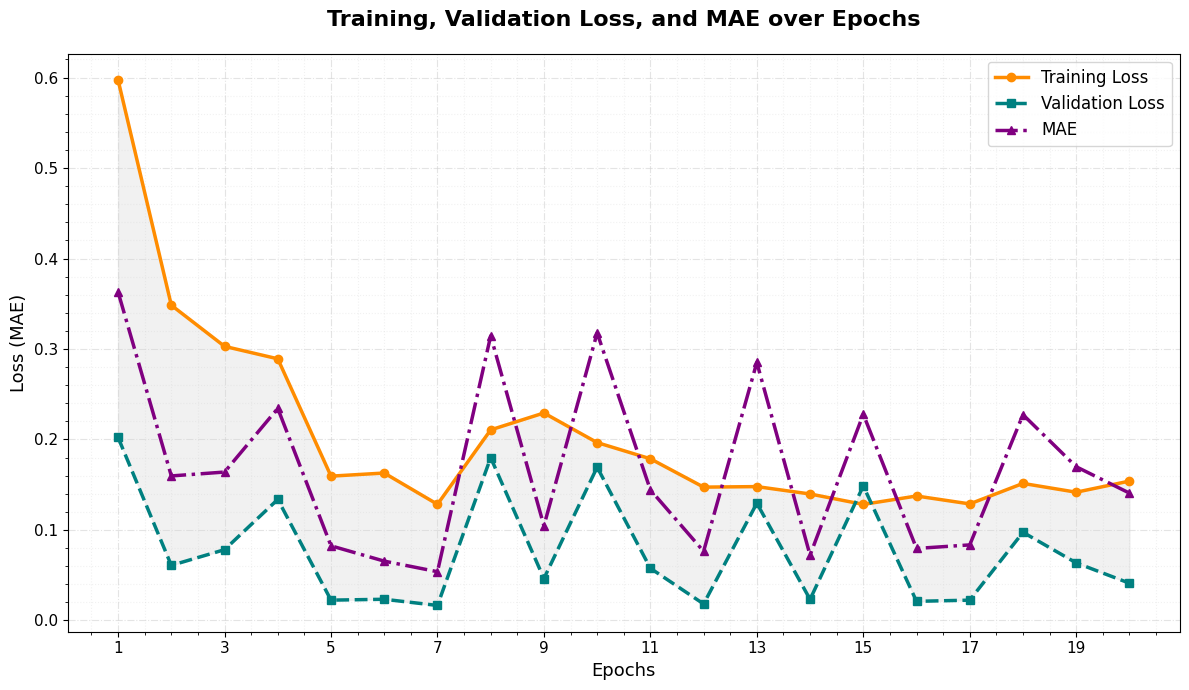

In [ ]:
plot_loss_and_mae_graph(train_loss_arr2, val_loss_arr2, mae_arr2)

### Model 3

In [ ]:
model3 = RNNModel(hyperparams3["input_size"], hyperparams3["hidden_size"], hyperparams3["num_layers"], hyperparams3["output_size"])
model3.to(device)
model3.load_data(X_train, X_val, y_train, y_val, batch_size=hyperparams3["batch_size"])
train_loss_arr3, val_loss_arr3, mae_arr3 = model3.train_model(loss="MSE", optimizer="Adam", lr=hyperparams3["learning_rate"], num_epochs=hyperparams3["num_epochs"])
mse_loss3, mae_loss3 = model3.get_loss(X_test, y_test)
print(f'Test Loss (MSE): {round(mse_loss3, 3)}, Test Loss (MAE): {round(mae_loss3, 3)}')

Epoch [1/20], Train Loss: 1.485, Validation Loss: 0.083, Val MAE: 0.2
Epoch [2/20], Train Loss: 0.625, Validation Loss: 0.165, Val MAE: 0.271
Epoch [3/20], Train Loss: 0.511, Validation Loss: 0.118, Val MAE: 0.224
Epoch [4/20], Train Loss: 0.438, Validation Loss: 0.165, Val MAE: 0.28
Epoch [5/20], Train Loss: 0.384, Validation Loss: 0.116, Val MAE: 0.228
Epoch [6/20], Train Loss: 0.338, Validation Loss: 0.055, Val MAE: 0.151
Epoch [7/20], Train Loss: 0.316, Validation Loss: 0.057, Val MAE: 0.148
Epoch [8/20], Train Loss: 0.293, Validation Loss: 0.029, Val MAE: 0.085
Epoch [9/20], Train Loss: 0.285, Validation Loss: 0.047, Val MAE: 0.116
Epoch [10/20], Train Loss: 0.271, Validation Loss: 0.031, Val MAE: 0.095
Epoch [11/20], Train Loss: 0.273, Validation Loss: 0.035, Val MAE: 0.116
Epoch [12/20], Train Loss: 0.268, Validation Loss: 0.042, Val MAE: 0.095
Epoch [13/20], Train Loss: 0.263, Validation Loss: 0.032, Val MAE: 0.116
Epoch [14/20], Train Loss: 0.263, Validation Loss: 0.023, Val M

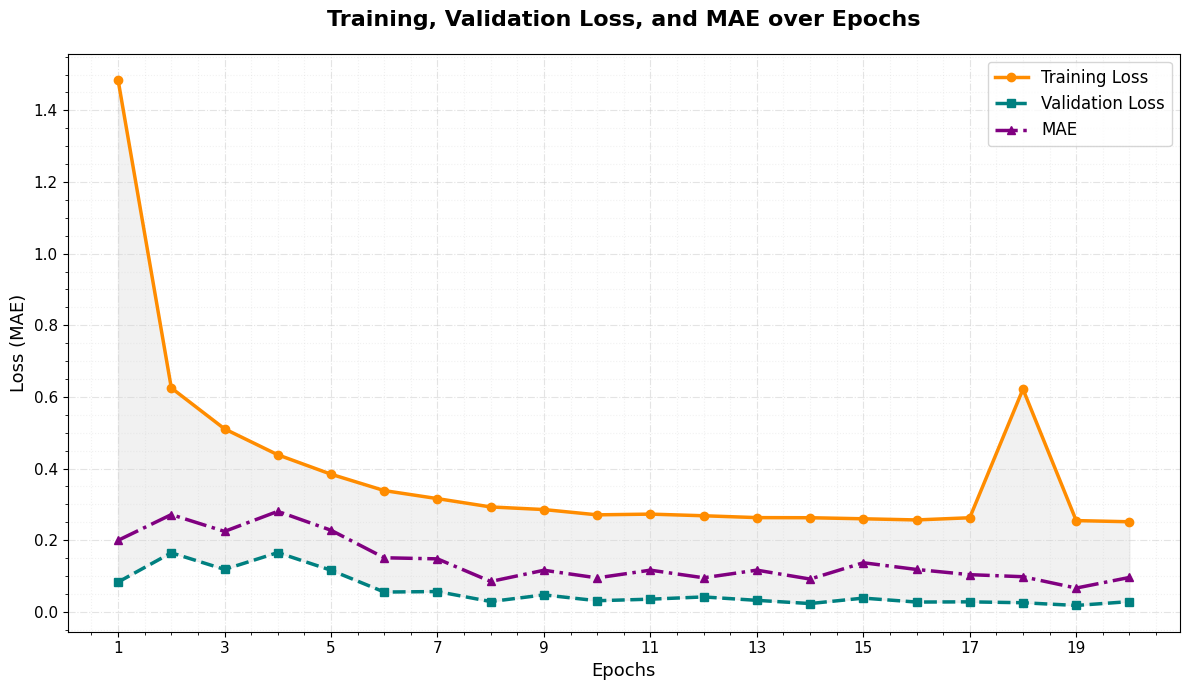

In [ ]:
plot_loss_and_mae_graph(train_loss_arr3, val_loss_arr3, mae_arr3)

### Model 4

In [8]:
model4 = RNNModel(hyperparams4["input_size"], hyperparams4["hidden_size"], hyperparams4["num_layers"], hyperparams4["output_size"])
model4.to(device)
model4.load_data(X_train, X_val, y_train, y_val, batch_size=hyperparams4["batch_size"])
train_loss_arr4, val_loss_arr4, mae_arr4 = model4.train_model(loss="MSE", optimizer="Adam", lr=hyperparams4["learning_rate"], num_epochs=hyperparams4["num_epochs"])
mse_loss4, mae_loss4 = model4.get_loss(X_test, y_test)
print(f'Test Loss (MSE): {round(mse_loss4, 3)}, Test Loss (MAE): {round(mae_loss4, 3)}')

Epoch [1/20], Train Loss: 0.801, Validation Loss: 0.446, Val MAE: 0.586
Epoch [2/20], Train Loss: 0.439, Validation Loss: 0.092, Val MAE: 0.186
Epoch [3/20], Train Loss: 0.347, Validation Loss: 0.103, Val MAE: 0.188
Epoch [4/20], Train Loss: 0.286, Validation Loss: 0.029, Val MAE: 0.068
Epoch [5/20], Train Loss: 0.275, Validation Loss: 0.068, Val MAE: 0.134
Epoch [6/20], Train Loss: 0.236, Validation Loss: 0.035, Val MAE: 0.102
Epoch [7/20], Train Loss: 0.227, Validation Loss: 0.019, Val MAE: 0.035
Epoch [8/20], Train Loss: 0.21, Validation Loss: 0.026, Val MAE: 0.086
Epoch [9/20], Train Loss: 0.205, Validation Loss: 0.068, Val MAE: 0.144
Epoch [10/20], Train Loss: 0.191, Validation Loss: 0.034, Val MAE: 0.103
Epoch [11/20], Train Loss: 0.192, Validation Loss: 0.037, Val MAE: 0.091
Epoch [12/20], Train Loss: 0.203, Validation Loss: 0.027, Val MAE: 0.093
Epoch [13/20], Train Loss: 0.185, Validation Loss: 0.037, Val MAE: 0.135
Epoch [14/20], Train Loss: 0.195, Validation Loss: 0.021, Val

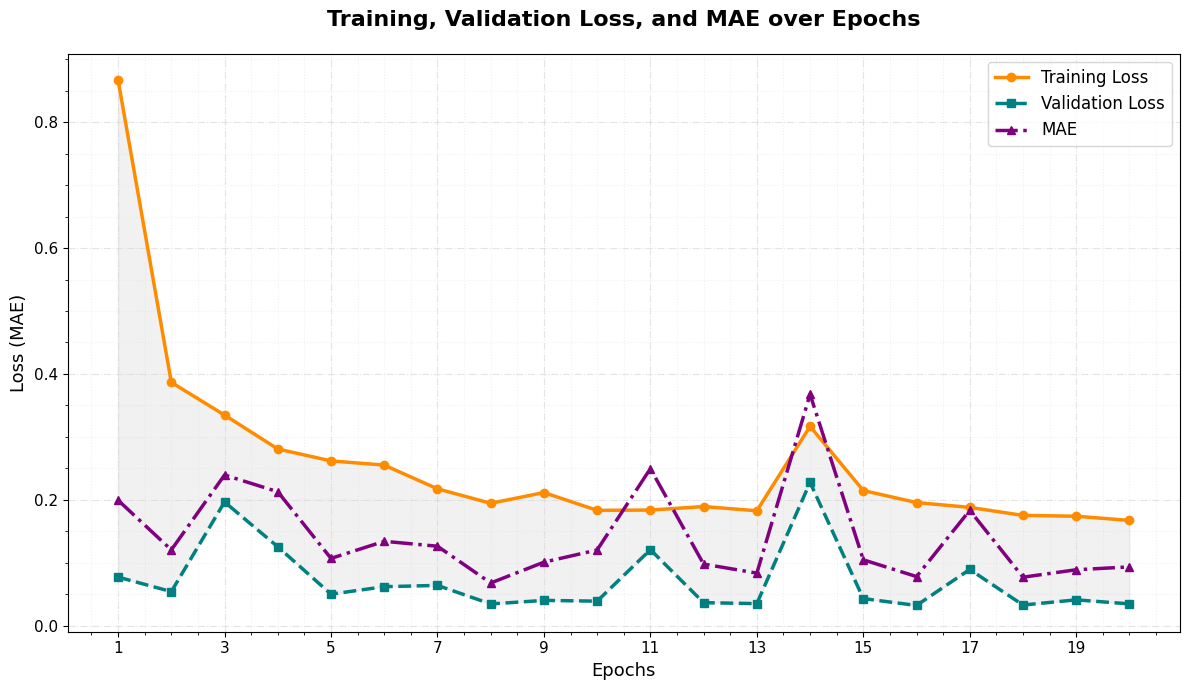

In [ ]:
plot_loss_and_mae_graph(train_loss_arr4, val_loss_arr4, mae_arr4)

### Model 5

In [ ]:
model5 = RNNModel(hyperparams5["input_size"], hyperparams5["hidden_size"], hyperparams5["num_layers"], hyperparams5["output_size"])
model5.to(device)
model5.load_data(X_train, X_val, y_train, y_val, batch_size=hyperparams5["batch_size"])
train_loss_arr5, val_loss_arr5, mae_arr5 = model5.train_model(loss="MSE", optimizer="Adam", lr=hyperparams5["learning_rate"], num_epochs=hyperparams5["num_epochs"])
mse_loss5, mae_loss5 = model5.get_loss(X_test, y_test)
print(f'Test Loss (MSE): {round(mse_loss5, 3)}, Test Loss (MAE): {round(mae_loss5, 3)}')

Epoch [1/20], Train Loss: 7.911, Validation Loss: 7.324, Val MAE: 2.251
Epoch [2/20], Train Loss: 7.465, Validation Loss: 7.381, Val MAE: 2.229
Epoch [3/20], Train Loss: 7.465, Validation Loss: 7.366, Val MAE: 2.28
Epoch [4/20], Train Loss: 7.465, Validation Loss: 7.335, Val MAE: 2.268
Epoch [5/20], Train Loss: 7.486, Validation Loss: 7.328, Val MAE: 2.263
Epoch [6/20], Train Loss: 7.463, Validation Loss: 7.353, Val MAE: 2.276
Epoch [7/20], Train Loss: 7.466, Validation Loss: 7.33, Val MAE: 2.265
Epoch [8/20], Train Loss: 7.469, Validation Loss: 7.418, Val MAE: 2.238
Epoch [9/20], Train Loss: 7.462, Validation Loss: 7.377, Val MAE: 2.228
Epoch [10/20], Train Loss: 7.467, Validation Loss: 7.372, Val MAE: 2.282
Epoch [11/20], Train Loss: 7.464, Validation Loss: 7.331, Val MAE: 2.265
Epoch [12/20], Train Loss: 7.465, Validation Loss: 7.33, Val MAE: 2.245
Epoch [13/20], Train Loss: 7.467, Validation Loss: 7.324, Val MAE: 2.25
Epoch [14/20], Train Loss: 7.466, Validation Loss: 7.338, Val MA

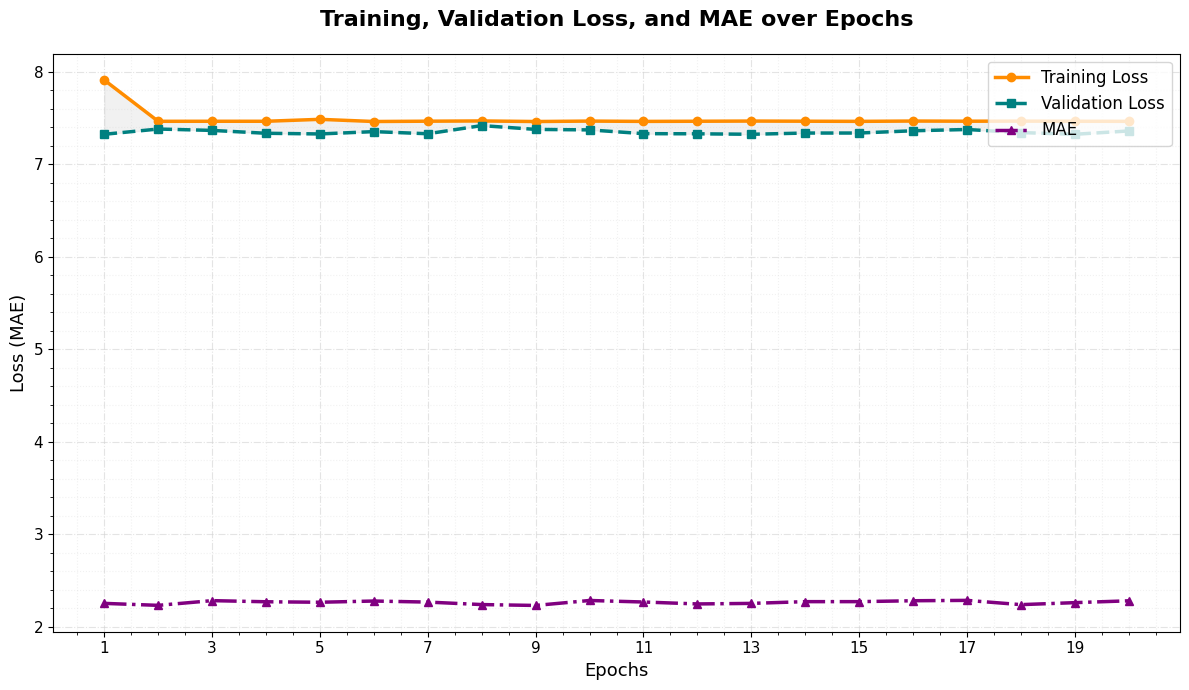

In [ ]:
plot_loss_and_mae_graph(train_loss_arr5, val_loss_arr5, mae_arr5)

> **We can clearly see that model 4 performed the best**

In [9]:
best_model = model4

## Comparing with random baseline

In [10]:
y_pred = list()

for x, true_label in zip(X_test, y_test):
    pred = np.random.randint(0, len(x) + 1)
    y_pred.append(pred)

mae_loss_random = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print(f'Test Loss for Random Baseline (MAE): {round(mae_loss_random, 3)}')

Test Loss for Random Baseline (MAE): 2.418


## Testing generalisation of model

In [11]:
# Generating 1000 samples of length > 16
num_sequences = 1000
sequences, labels = sequences_data_generator(num_sequences, 17, 20) # 17 and 20 both inclusive

# Using model 4 as it was our best model
mse_loss_generalisation, mae_loss_generalisation = best_model.get_loss(sequences, labels)
print(f'Generalisation Loss (MSE): {round(mse_loss_generalisation, 3)}, Generalisation Loss (MAE): {round(mae_loss_generalisation, 3)}')

Generalisation Loss (MSE): 4.05, Generalisation Loss (MAE): 1.991


## N_bits vs MAE Plot

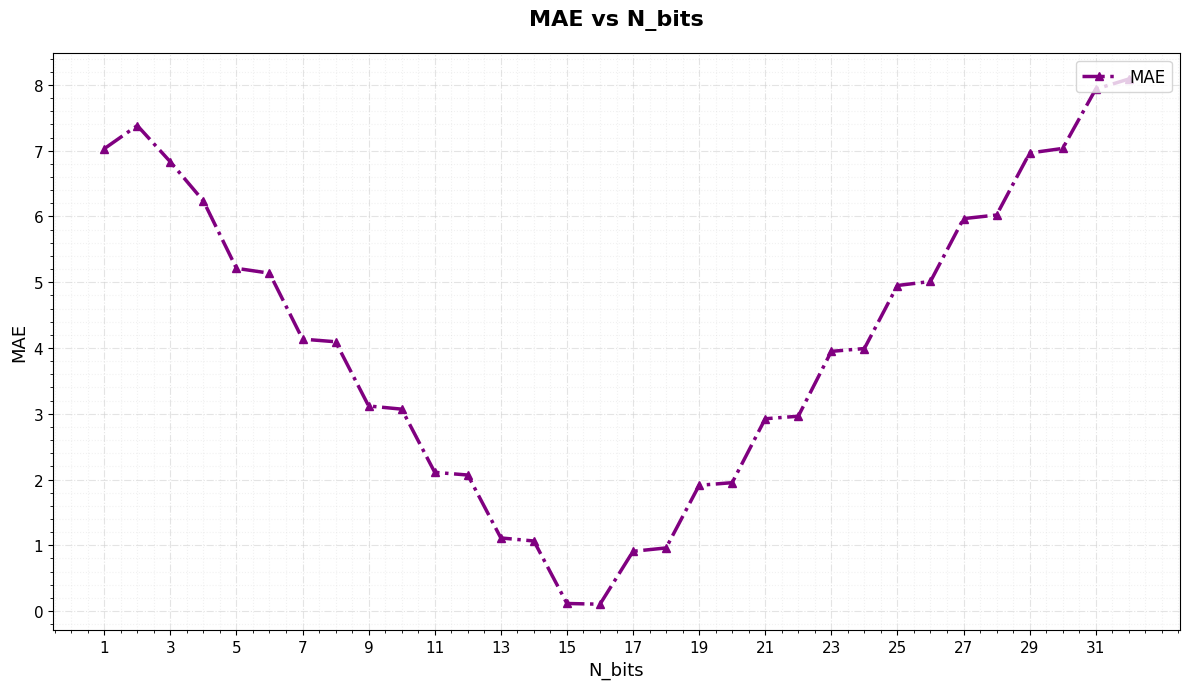

In [12]:
x_axis = range(1, 33)
y_axis = list()

for x in x_axis:
    sequences, labels = sequences_data_generator(1000, x, x) # Generating 1000 sequences of length x
    mse_loss, mae_loss = best_model.get_loss(sequences, labels)
    y_axis.append(mae_loss)

plt.figure(figsize=(12, 7))
plt.plot(x_axis, y_axis, color='purple', linestyle='-.', marker='^', label='MAE', linewidth=2.5)
plt.title('MAE vs N_bits', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('N_bits', fontsize=13)
plt.ylabel('MAE', fontsize=13)

plt.grid(True, linestyle='-.', color='lightgray', alpha=0.6)
plt.minorticks_on()
plt.grid(True, which='minor', linestyle=':', color='lightgray', alpha=0.3)

plt.xticks(x_axis[::2], fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

plt.legend(loc='upper right', fontsize=12)
plt.show()
plt.close()

**Explanation of the graph**
- **Initial High Error at 1 Bit**: High MAE for 1-bit sequences may result from simplicity and variability. The model might not capture sufficient complexity (data).
- **Decline Up to 16 Bits**: The model adapts as it encounters more varied training data, leading to reduced error up to 16 bits.
- **Rising Error Beyond 16 Bits**: Beyond the training range, MAE increases due to the model facing unseen sequences, highlighting limited generalization and learned representations.
